# Predicting E-Commerce Product Recommendations

__Background:__

NLP problem with data from an E-Commerce store of women's clothing. Each record is a customer's review. 

<br/>

__Objectives:__

Create a supervised predictive model to predict if future products are recommended by the customer or not. 

<br/>

__Dataset info:__
* Clothing ID
* Review Title
* Review
* Age of customer
* Rating (1 = worst , 5 = Best)
* Recommended_IND (1 = recommended , 0 = not recommended)
* Positive_Feedback_Count (the number of other customers who found this review positive)
* Division Name
* Department Name

<br/>

__Summary of Project:__
1. Data Retrieval and Understanding
2. Exploratory Data Analysis and Visualization
3. Feature Engineering and Predictive Modeling
    * Model 1 - Basic NLP Features 
    * Model 2 - Feature Sentiment Analysis
    * Model 3 - BOW based Features on Clean Text vs Recommended
    * Model 4 - BOW based Features on Clean Text vs Rating

## Phase 1: Data Retrieval and Understanding

* Combine the review ‘Title’ and ‘Review Text’ into a single column of text data
* Remove any empty review cells

In [1]:
import pandas as pd

df = pd.read_csv('Womens Clothing E-Commerce Reviews - NLP.csv', keep_default_na=False)
df.head()
print(df.dtypes)
df.columns = [x.strip().replace(' ','_') for x in df.columns]

df.count()
df.isna().sum()


Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object


Clothing_ID                0
Age                        0
Title                      0
Review_Text                0
Rating                     0
Recommended_IND            0
Positive_Feedback_Count    0
Division_Name              0
Department_Name            0
Class_Name                 0
dtype: int64

In [2]:
df["text_data"] = df["Title"].astype(str) + df["Review_Text"].astype(str)
df.drop(columns=["Title","Review_Text"], inplace = True)

In [3]:
print("Sum before removing empty cells: \n",sum(df['text_data'] == ''))

df = df[df['text_data'] != ''] #remove empty cells

print("Sum after removing empty cells: \n", sum(df['text_data'] == ''))

Sum before removing empty cells: 
 844
Sum after removing empty cells: 
 0


In [4]:
def set_label_recommend(Recommended_IND):
    if Recommended_IND == 1:
        return 'Recommended'
    else:
        return 'Not_Recommended'

df['label_recommended'] = df.Recommended_IND.apply(lambda x: set_label_recommend(x)) 
#creating a recommended column with strings only


df.columns

Index(['Clothing_ID', 'Age', 'Rating', 'Recommended_IND',
       'Positive_Feedback_Count', 'Division_Name', 'Department_Name',
       'Class_Name', 'text_data', 'label_recommended'],
      dtype='object')

In [5]:
df_int_columnt = df[["Age","Rating","Recommended_IND","Positive_Feedback_Count","Clothing_ID"]]
df_int_columnt.agg(['min','max','median','mean','std','nunique']).T

,min,max,median,mean,std,nunique
Age,18.0,99.0,41.0,43.279790,12.327023,77.0
Rating,1.0,5.0,5.0,4.183597,1.115751,5.0
Recommended_IND,0.0,1.0,1.0,0.818876,0.385129,2.0
Positive_Feedback_Count,0.0,122.0,1.0,2.630466,5.786062,82.0
Clothing_ID,1.0,1205.0,936.0,919.340164,202.265815,1179.0


## Phase 2: Exploratory Data Analysis

Visualize the distribution of a few columns of interest
* Recommended products - (Recommended_IND)
* Rating
* Rating vs Recommendations
* Product Class Name, Department Name, etc. (string Class_Name vs Department_Name)
* Age, Feedback on Reviews
* Top Product IDs 

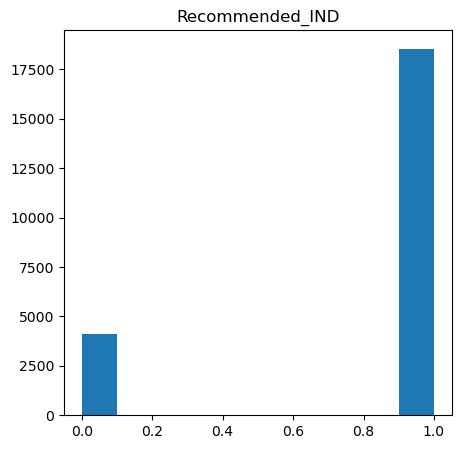

In [6]:
#Recommended products - (Recommended_IND)
df.dtypes
ax = df.hist(column='Recommended_IND',grid=False, figsize=(5,5))
#0 = not recommended, 1 = recommended

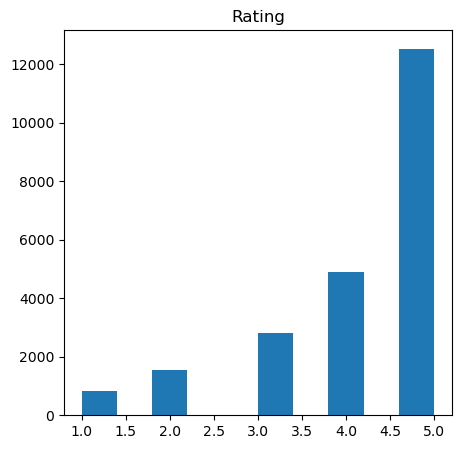

In [7]:
ax = df.hist(column='Rating', grid=False, figsize=(5,5))
#1 = worst , 5 = Best

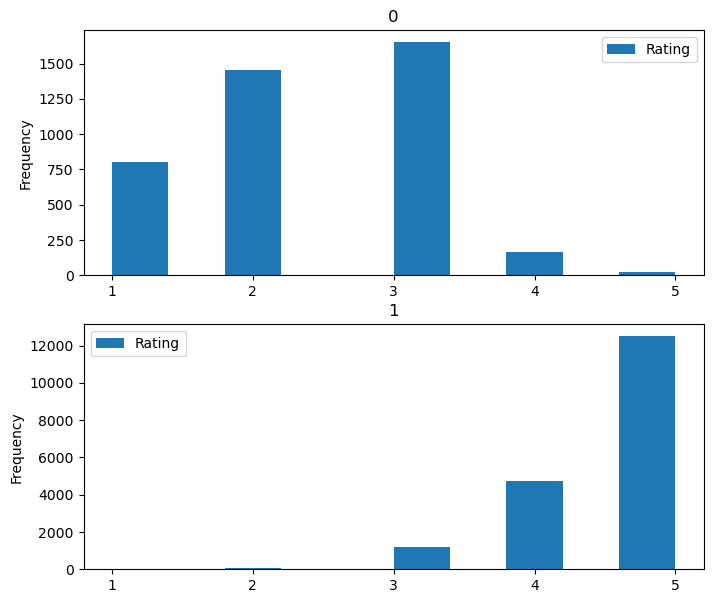

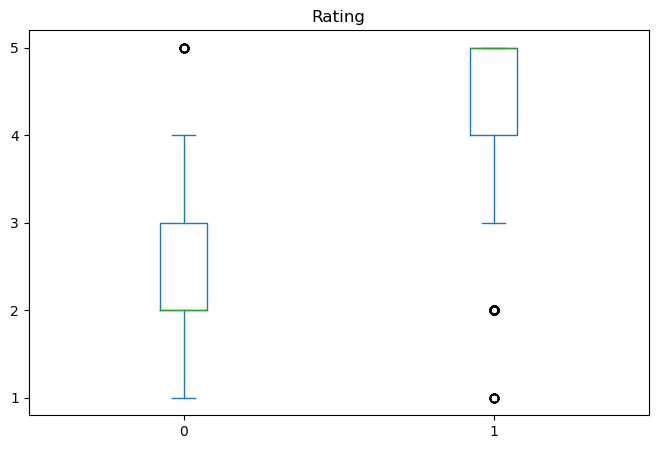

In [8]:
#Rating vs Recommendations

df.Rating.unique()

%matplotlib inline
import matplotlib.pylab as plt


ax = df.plot.hist(column=["Rating"], by="Recommended_IND", figsize=(8, 7),xticks=[1.0,2.0,3.0,4.0,5.0])

ax2 = df.plot(column=["Rating"], by="Recommended_IND", figsize=(8, 5),kind="box",yticks=[1.0,2.0,3.0,4.0,5.0])


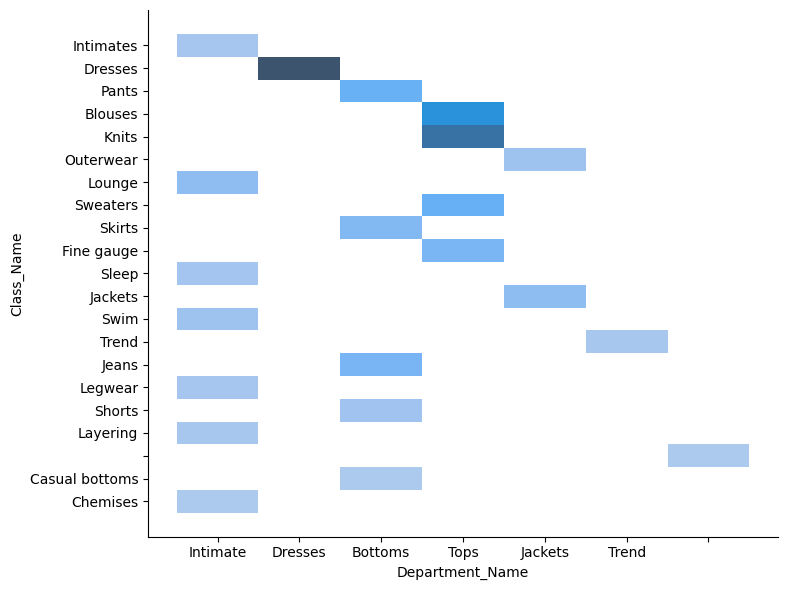

In [9]:
#Product Class Name, Department Name
import seaborn as sns

sns.displot(df,x='Department_Name', y='Class_Name', height=6, aspect=1.33);

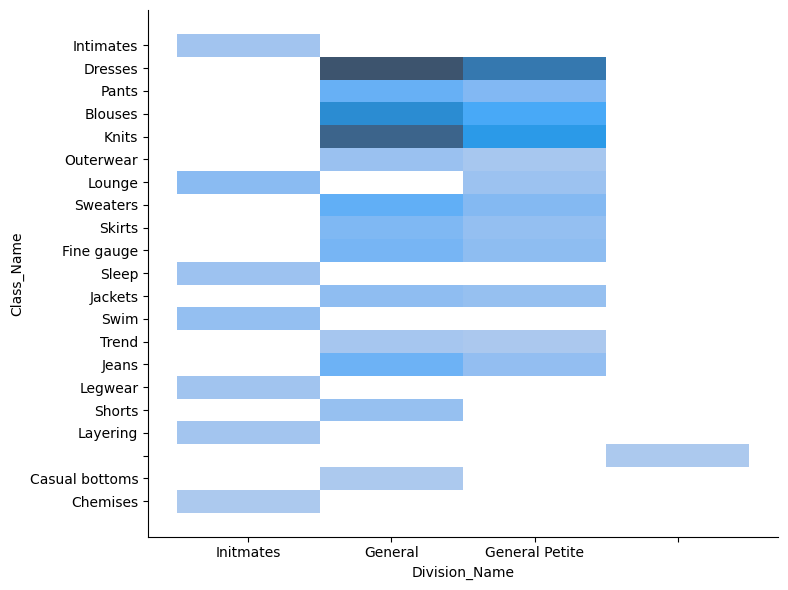

In [10]:
sns.displot(df,x='Division_Name', y='Class_Name', height=6, aspect=1.33);

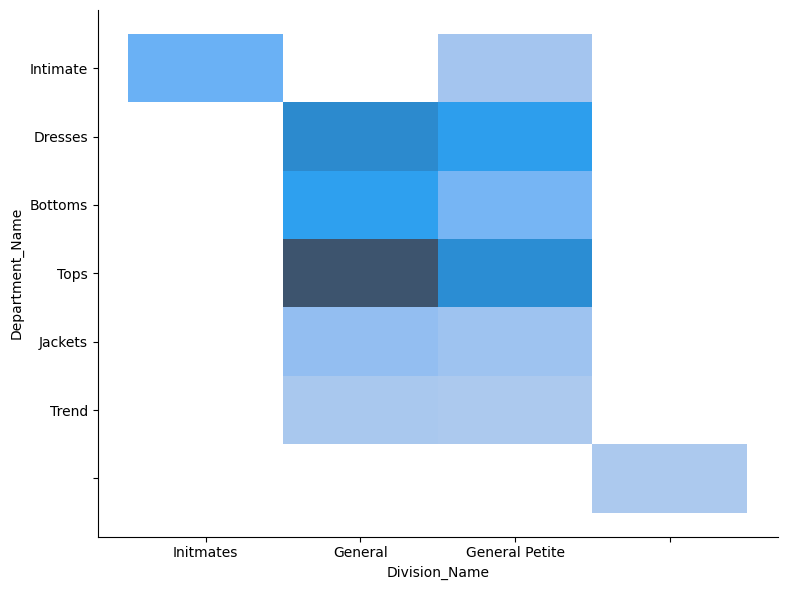

In [11]:
sns.displot(df,x='Division_Name', y='Department_Name', height=6, aspect=1.33);

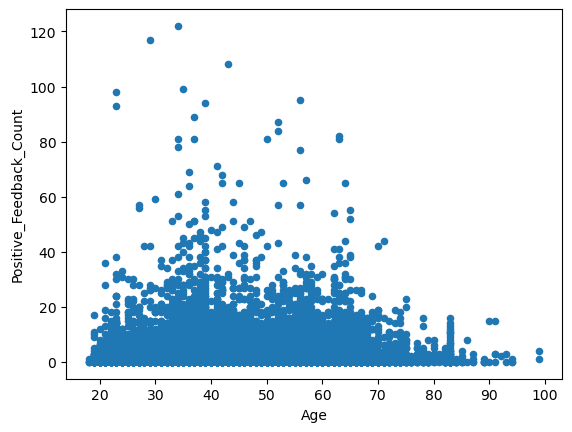

In [12]:
#Age vs Feedback on Reviews count
df.plot(kind='scatter', y='Positive_Feedback_Count' , x='Age');

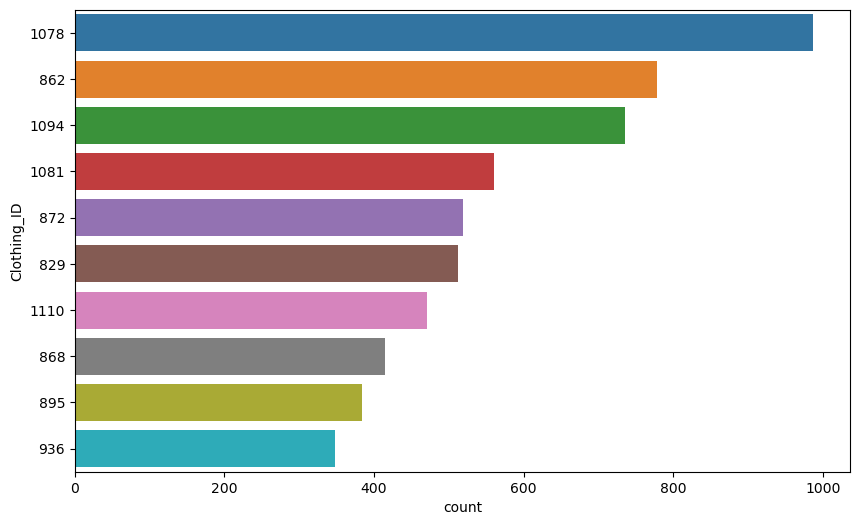

In [13]:
#top 10 clothing ID
plt.figure(figsize=(10, 6))
sns.countplot(y='Clothing_ID', data=df, order=df['Clothing_ID'].value_counts().iloc[:10].index);

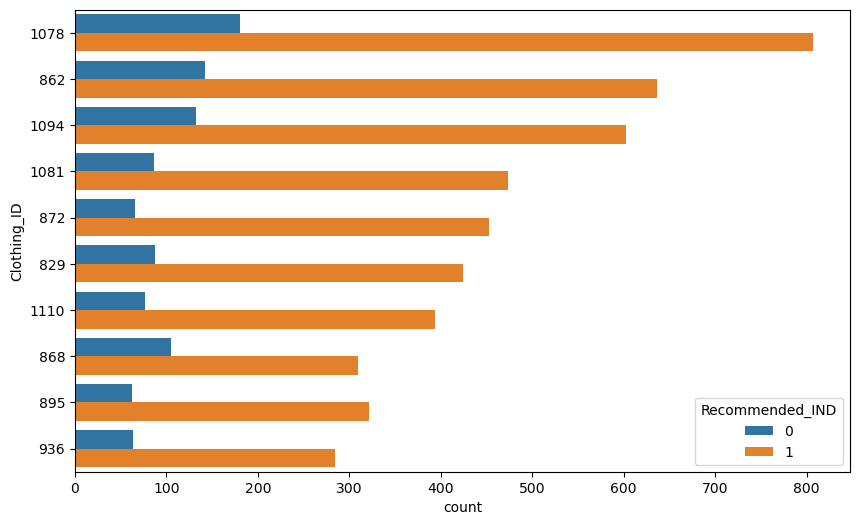

In [14]:
#top 10 clothing ID split into recommended(1) and not recommended(0)
plt.figure(figsize=(10, 6))
sns.countplot(y='Clothing_ID', data=df, hue='Recommended_IND', order=df['Clothing_ID'].value_counts().iloc[:10].index);

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\faywa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


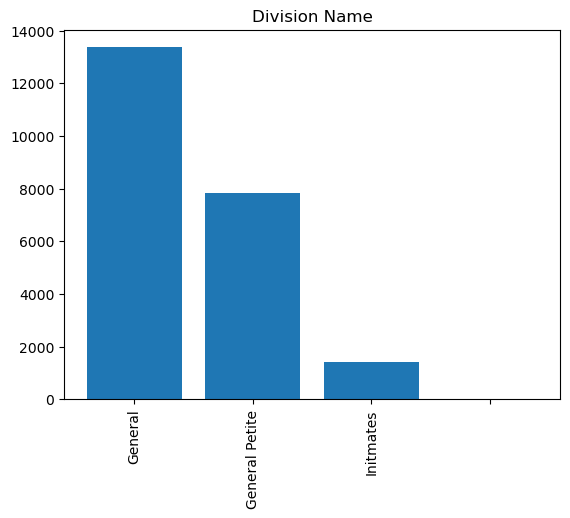

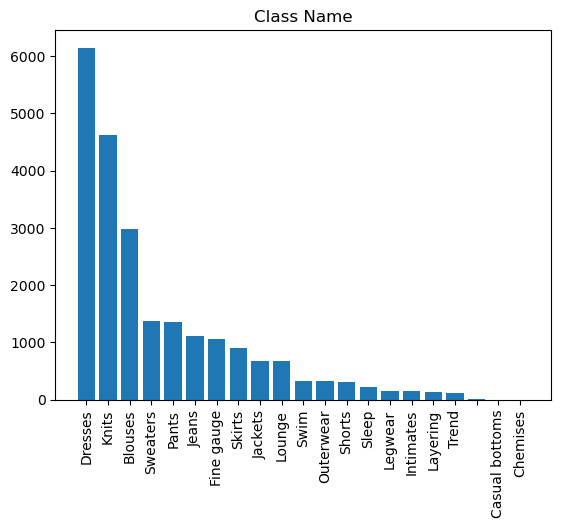

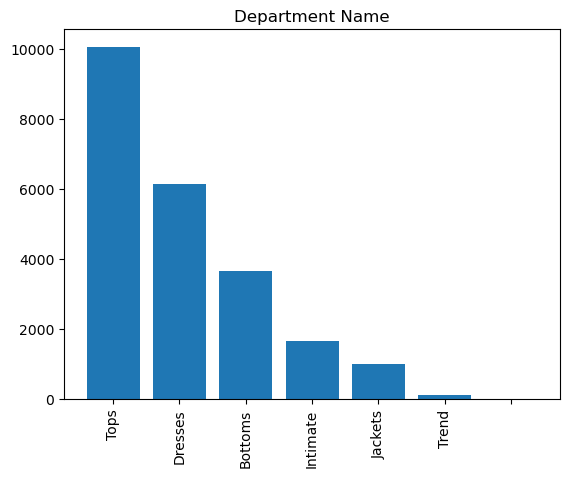

In [15]:
#count of division, class and department name
from clothing_reviews_data_functions import histogram_string

histogram_string(df.Division_Name,"Division Name")
histogram_string(df.Class_Name,"Class Name")
histogram_string(df.Department_Name,"Department Name")

## Phase 3: Feature Engineering and Predictive Modeling

* Basic NLP Features
* Sentiment Analysis features
* BOW-based features 1,2,3-grams
    * Count Vectorizer based features
    * TF-IDF based features
    * Trying out a wide variety of machine learning models and comparing their performance



### Model 1 - Basic NLP Features

Analyze the distribution of textual data in terms of:
* Review lengths
* Number of words per review
* word density
* punctuation count
* title word count
* uppercase word count


Using Logistic regression model

In [16]:
df_basic = df[["text_data","Age","Positive_Feedback_Count","Recommended_IND"]]

import string
df_basic['letter_count'] = df_basic['text_data'].apply(lambda n: len(n))
df_basic['word_count'] = df_basic['text_data'].apply(lambda n: len(n.split()))
df_basic['word_density'] = df_basic['letter_count'] / (df_basic['word_count']+1)
df_basic['punctuation_count'] = df_basic['text_data'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df_basic['title_word_count'] = df_basic['text_data'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df_basic['upper_case_word_count'] = df_basic['text_data'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


In [17]:
df_basic.agg(['min','max','median','mean','std']).T

,min,max,median,mean,std
text_data,"""beach business""Great for the beachy business ...",~~so very retailer~~Absolutely beautiful - \nu...,NaN,NaN,NaN
Age,18.0,99.0,41.0,43.27979,12.327023
Positive_Feedback_Count,0.0,122.0,1.0,2.630466,5.786062
Recommended_IND,0.0,1.0,1.0,0.818876,0.385129
letter_count,11.0,556.0,318.0,325.127595,147.186675
word_count,2.0,120.0,61.0,62.231561,29.022568
word_density,3.5,8.75,5.14433,5.177909,0.371809
punctuation_count,0.0,60.0,10.0,10.62203,6.023332
title_word_count,0.0,2.0,1.0,0.928849,0.279473
upper_case_word_count,0.0,2.0,0.0,0.060463,0.238718


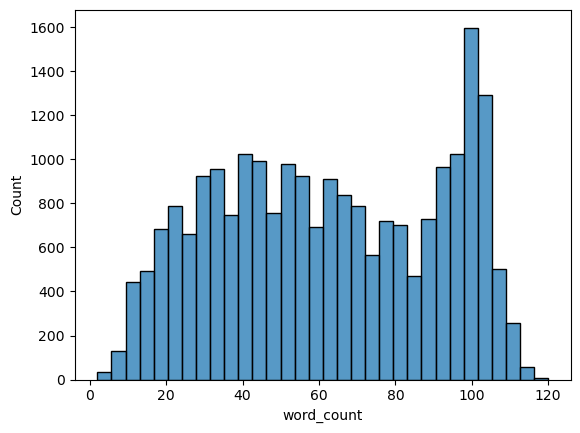

In [18]:
#number of words
sns.histplot(df_basic.word_count);

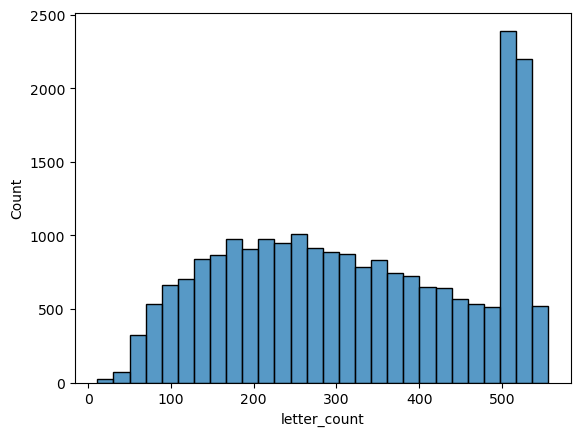

In [19]:
#length of reviews
sns.histplot(df_basic.letter_count);

In [20]:
from clothing_reviews_data_functions import LR_model

LR_model(df_basic.drop(columns = ['text_data'])) 
#performance of logistic regression on all the above features vs recommended reviews

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1218
           1       0.82      1.00      0.90      5575

    accuracy                           0.82      6793
   macro avg       0.41      0.50      0.45      6793
weighted avg       0.67      0.82      0.74      6793



,not_recommended,recommended
not_recommended,0,1218
recommended,2,5573


In [21]:
#create accuracy dataset
data =  ['Features_Used','Training_Accuracy','Test_Accuracy'] 
lr_accuracy = pd.DataFrame(index=data)

lr_accuracy

""
Features_Used
Training_Accuracy
Test_Accuracy


In [22]:
from clothing_reviews_data_functions import accuracy_LR

#add accuracy score of Basic NLP features to the accuracy dataset
lr_accuracy['Basic_NLP_Features'] = accuracy_LR(df_basic.drop(columns = ['text_data']), 
                            Features_Used = "Age, Feedback count, letter count, word count, word density, punctuation count, title word count, upper case word count")

lr_accuracy

,Basic_NLP_Features
Features_Used,"Age, Feedback count, letter count, word count,..."
Training_Accuracy,0.8175
Test_Accuracy,0.8204


### Model 2 - Feature Sentiment Analysis
using Logistic regression

In [23]:
from clothing_reviews_data_functions import normalize_corpus

text_data_values = df.text_data.values.tolist()#normalize the text data 
norm_text_data = normalize_corpus(text_data_values)
norm_text_data
df['Clean_text'] = norm_text_data #add a column of clean text(normalized reviews) to the dataset

100%|██████████| 22642/22642 [00:39<00:00, 570.04it/s]


In [24]:
import textblob

df1 = df[["Clean_text","Age","Positive_Feedback_Count","Recommended_IND"]] 

df_snt_obj = df1['Clean_text'].apply(lambda row: textblob.TextBlob(row).sentiment)
df1['Polarity'] = [obj.polarity for obj in df_snt_obj.values]
df1['Subjectivity'] = [obj.subjectivity for obj in df_snt_obj.values]

df1.head()

,Clean_text,Age,Positive_Feedback_Count,Recommended_IND,Polarity,Subjectivity
0,absolutely wonderful silky sexy comfortable,33,0,1,0.633333,0.933333
1,love dress pretty happened find store glad nev...,34,4,1,0.318750,0.725000
2,major design flawsi high hope dress really wan...,60,0,0,0.062413,0.345866
3,favorite buy love love love jumpsuit fun flirt...,50,0,1,0.500000,0.678571
4,flattering shirthis shirt flattering due adjus...,47,6,1,0.458333,0.658333


In [25]:
LR_model(df1.drop(columns = ['Clean_text'])) 

              precision    recall  f1-score   support

           0       0.69      0.17      0.27      1218
           1       0.84      0.98      0.91      5575

    accuracy                           0.84      6793
   macro avg       0.76      0.57      0.59      6793
weighted avg       0.82      0.84      0.79      6793



,not_recommended,recommended
not_recommended,201,1017
recommended,92,5483


In [26]:
lr_accuracy['Sentiment_Analysis'] = accuracy_LR(df1.drop(columns = ['Clean_text']), 
                                                Features_Used = "Age, Feedback count, polarity, subjectivity")
lr_accuracy

,Basic_NLP_Features,Sentiment_Analysis
Features_Used,"Age, Feedback count, letter count, word count,...","Age, Feedback count, polarity, subjectivity"
Training_Accuracy,0.8175,0.8342
Test_Accuracy,0.8204,0.8367


**Accuracy Visualization of Logistic Regression**
* Sentiment analysis 
* Basic NLP

Text(0.5, 1.0, 'Accuracy of Logistic Regression Models')

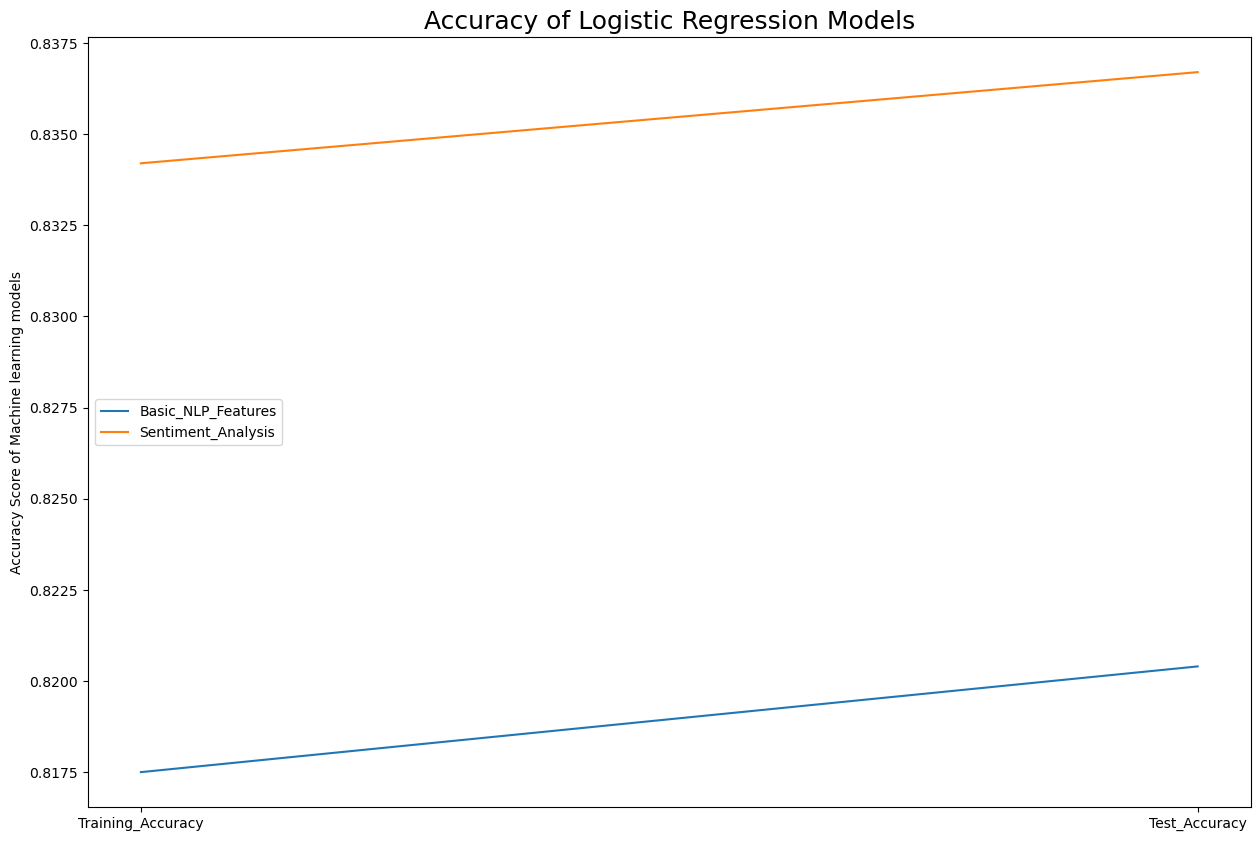

In [27]:
lr_accuracy

lr_accuracy_2 = lr_accuracy.iloc[1:]#remove feature name

fig = plt.figure(figsize = (15,10))
ax = plt.axes()

ax.plot(lr_accuracy_2,  label=lr_accuracy_2.columns) 
#create line graph of accuracy logistic regression analysis performed above

plt.legend(loc = 'center left')
plt.ylabel('Accuracy Score of Machine learning models') 
plt.title("Accuracy of Logistic Regression Models",fontsize=18)

### Model 3 - Clean Text vs Recommended
* Bag of words based features - (1-3)-gram
    - Count Vectorizer
    - TF-IDF
* Predictive Analytics Models
    - Naive Bayes
    - Logistic Regression
    - Random Forest

In [28]:
from clothing_reviews_data_functions import get_top_ngrams 
#analyze the different n-grams to determine appropriate number for future analysis

get_top_ngrams(corpus=norm_text_data, ngram_val=1, limit=10)

[('not', 18307),
 ('dress', 12183),
 ('fit', 10498),
 ('love', 10119),
 ('size', 9628),
 ('top', 8869),
 ('great', 7676),
 ('like', 7359),
 ('color', 7244),
 ('look', 7062)]

In [29]:
get_top_ngrams(corpus=norm_text_data, ngram_val=2, limit=10)

[('doe not', 1529),
 ('true size', 1350),
 ('fit perfectly', 1093),
 ('look great', 926),
 ('look like', 831),
 ('love dress', 812),
 ('usually wear', 687),
 ('could not', 673),
 ('fit well', 667),
 ('well made', 635)]

In [30]:
get_top_ngrams(corpus=norm_text_data, ngram_val=3, limit=10)
#I will use (1,3)ngram which is 1,2, and 3-gram 

[('fit true size', 488),
 ('canot wait wear', 254),
 ('run true size', 200),
 ('love love love', 191),
 ('size fit perfectly', 170),
 ('doe not look', 169),
 ('received many compliment', 165),
 ('small fit perfectly', 147),
 ('usually wear size', 137),
 ('fit like glove', 136)]

In [31]:
#Trying out a wide variety of machine learning models on BOW features and comparing their performance
df2 = df[["Clean_text","label_recommended"]]

df2.columns

Index(['Clean_text', 'label_recommended'], dtype='object')

In [32]:
#create an accuracy dataset
data =  ['Features_Used','Training_CV','Test_CV','Training_TFIDF','Test_TFIDF',] 
accuracy_df = pd.DataFrame(index=data)

accuracy_df


""
Features_Used
Training_CV
Test_CV
Training_TFIDF
Test_TFIDF


In [33]:
from clothing_reviews_data_functions import cv_evaluateClassifier
from clothing_reviews_data_functions import tv_evaluateClassifier
from clothing_reviews_data_functions import accuracy_score_BOW

In [34]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=1.0) #performing Naive bayes model 

#perfoming count vectorizer based features and analyzing its performance
print(cv_evaluateClassifier(nb,df2['Clean_text'], df2['label_recommended']))
print('-'*100)
#performing TF-IDF based features and analyzing its performance
print(tv_evaluateClassifier(nb,df2['Clean_text'], df2['label_recommended']))

accuracy_df['Naive_bayes_0'] = accuracy_score_BOW(nb, df2['Clean_text'], df2['label_recommended'], "Recommended")

accuracy_df

Count Vectorizer based features and MultinomialNB() Model 

                 precision    recall  f1-score   support

Not_Recommended       0.97      0.10      0.18      1218
    Recommended       0.84      1.00      0.91      5575

       accuracy                           0.84      6793
      macro avg       0.90      0.55      0.55      6793
   weighted avg       0.86      0.84      0.78      6793

                 Not_Recommended  Recommended
Not_Recommended              123         1095
Recommended                    4         5571
----------------------------------------------------------------------------------------------------
TF-IDF based features and MultinomialNB() Model 

                 precision    recall  f1-score   support

Not_Recommended       0.00      0.00      0.00      1218
    Recommended       0.82      1.00      0.90      5575

       accuracy                           0.82      6793
      macro avg       0.41      0.50      0.45      6793
   weighted avg    

,Naive_bayes_0
Features_Used,Recommended
Training_CV,0.9984
Test_CV,0.8382
Training_TFIDF,0.8182
Test_TFIDF,0.8207


In [35]:
print(cv_evaluateClassifier(nb,df2['Clean_text'], df2['label_recommended'],min_df = 3))
print('-'*100)
print(tv_evaluateClassifier(nb,df2['Clean_text'], df2['label_recommended'],min_df = 3))

accuracy_df['Naive_bayes_3'] = accuracy_score_BOW(nb, df2['Clean_text'], df2['label_recommended'], "Recommended",min_df = 3)

accuracy_df

Count Vectorizer based features and MultinomialNB() Model 

                 precision    recall  f1-score   support

Not_Recommended       0.71      0.78      0.75      1218
    Recommended       0.95      0.93      0.94      5575

       accuracy                           0.90      6793
      macro avg       0.83      0.86      0.84      6793
   weighted avg       0.91      0.90      0.91      6793

                 Not_Recommended  Recommended
Not_Recommended              955          263
Recommended                  389         5186
----------------------------------------------------------------------------------------------------
TF-IDF based features and MultinomialNB() Model 

                 precision    recall  f1-score   support

Not_Recommended       0.99      0.07      0.13      1218
    Recommended       0.83      1.00      0.91      5575

       accuracy                           0.83      6793
      macro avg       0.91      0.53      0.52      6793
   weighted avg    

,Naive_bayes_0,Naive_bayes_3
Features_Used,Recommended,Recommended
Training_CV,0.9984,0.9385
Test_CV,0.8382,0.904
Training_TFIDF,0.8182,0.8501
Test_TFIDF,0.8207,0.8329


In [36]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1)#performing Logistic regression model 

print(cv_evaluateClassifier(lr, df2['Clean_text'], df2['label_recommended']))
print('-'*100)
print(tv_evaluateClassifier(lr, df2['Clean_text'], df2['label_recommended']))

accuracy_df['Logistic_Regression_0'] = accuracy_score_BOW(lr, df2['Clean_text'], df2['label_recommended'], "Recommended")

accuracy_df
    

Count Vectorizer based features and LogisticRegression(random_state=1) Model 

                 precision    recall  f1-score   support

Not_Recommended       0.81      0.64      0.72      1218
    Recommended       0.93      0.97      0.95      5575

       accuracy                           0.91      6793
      macro avg       0.87      0.81      0.83      6793
   weighted avg       0.90      0.91      0.90      6793

                 Not_Recommended  Recommended
Not_Recommended              784          434
Recommended                  186         5389
----------------------------------------------------------------------------------------------------
TF-IDF based features and LogisticRegression(random_state=1) Model 

                 precision    recall  f1-score   support

Not_Recommended       0.87      0.47      0.61      1218
    Recommended       0.90      0.98      0.94      5575

       accuracy                           0.89      6793
      macro avg       0.88      0.73  

,Naive_bayes_0,Naive_bayes_3,Logistic_Regression_0
Features_Used,Recommended,Recommended,Recommended
Training_CV,0.9984,0.9385,0.9999
Test_CV,0.8382,0.904,0.9087
Training_TFIDF,0.8182,0.8501,0.897
Test_TFIDF,0.8207,0.8329,0.8928


In [37]:
print(cv_evaluateClassifier(lr, df2['Clean_text'], df2['label_recommended'],min_df = 3))
print('-'*100)
print(tv_evaluateClassifier(lr, df2['Clean_text'], df2['label_recommended'],min_df = 3))

accuracy_df['Logistic_Regression_3'] = accuracy_score_BOW(lr, df2['Clean_text'], df2['label_recommended'],
                                                          "Recommended",min_df = 3)

accuracy_df

Count Vectorizer based features and LogisticRegression(random_state=1) Model 

                 precision    recall  f1-score   support

Not_Recommended       0.80      0.68      0.73      1218
    Recommended       0.93      0.96      0.95      5575

       accuracy                           0.91      6793
      macro avg       0.86      0.82      0.84      6793
   weighted avg       0.91      0.91      0.91      6793

                 Not_Recommended  Recommended
Not_Recommended              830          388
Recommended                  214         5361
----------------------------------------------------------------------------------------------------
TF-IDF based features and LogisticRegression(random_state=1) Model 

                 precision    recall  f1-score   support

Not_Recommended       0.87      0.52      0.65      1218
    Recommended       0.90      0.98      0.94      5575

       accuracy                           0.90      6793
      macro avg       0.89      0.75  

,Naive_bayes_0,Naive_bayes_3,Logistic_Regression_0,Logistic_Regression_3
Features_Used,Recommended,Recommended,Recommended,Recommended
Training_CV,0.9984,0.9385,0.9999,0.9985
Test_CV,0.8382,0.904,0.9087,0.9114
Training_TFIDF,0.8182,0.8501,0.897,0.9243
Test_TFIDF,0.8207,0.8329,0.8928,0.9005


In [38]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=1)#performing Random Forest model 

print(cv_evaluateClassifier(rfc, df2['Clean_text'], df2['label_recommended']))
print('-'*100)
print(tv_evaluateClassifier(rfc, df2['Clean_text'], df2['label_recommended']))

accuracy_df['Random_Forest_0'] = accuracy_score_BOW(rfc, df2['Clean_text'], df2['label_recommended'], "Recommended")

accuracy_df

Count Vectorizer based features and RandomForestClassifier(random_state=1) Model 

                 precision    recall  f1-score   support

Not_Recommended       0.92      0.09      0.16      1218
    Recommended       0.83      1.00      0.91      5575

       accuracy                           0.84      6793
      macro avg       0.88      0.54      0.54      6793
   weighted avg       0.85      0.84      0.78      6793

                 Not_Recommended  Recommended
Not_Recommended              110         1108
Recommended                    9         5566
----------------------------------------------------------------------------------------------------
TF-IDF based features and RandomForestClassifier(random_state=1) Model 

                 precision    recall  f1-score   support

Not_Recommended       0.89      0.21      0.34      1218
    Recommended       0.85      0.99      0.92      5575

       accuracy                           0.85      6793
      macro avg       0.87    

,Naive_bayes_0,Naive_bayes_3,Logistic_Regression_0,Logistic_Regression_3,Random_Forest_0
Features_Used,Recommended,Recommended,Recommended,Recommended,Recommended
Training_CV,0.9984,0.9385,0.9999,0.9985,1.0
Test_CV,0.8382,0.904,0.9087,0.9114,0.8356
Training_TFIDF,0.8182,0.8501,0.897,0.9243,1.0
Test_TFIDF,0.8207,0.8329,0.8928,0.9005,0.8538


In [39]:
print(cv_evaluateClassifier(rfc, df2['Clean_text'], df2['label_recommended'],min_df = 3))
print('-'*100)
print(tv_evaluateClassifier(rfc, df2['Clean_text'], df2['label_recommended'],min_df = 3))

accuracy_df['Random_Forest_3'] = accuracy_score_BOW(rfc, df2['Clean_text'], df2['label_recommended'], 
                                                    "Recommended",min_df = 3)

accuracy_df

Count Vectorizer based features and RandomForestClassifier(random_state=1) Model 

                 precision    recall  f1-score   support

Not_Recommended       0.89      0.28      0.43      1218
    Recommended       0.86      0.99      0.92      5575

       accuracy                           0.87      6793
      macro avg       0.88      0.64      0.68      6793
   weighted avg       0.87      0.87      0.84      6793

                 Not_Recommended  Recommended
Not_Recommended              346          872
Recommended                   44         5531
----------------------------------------------------------------------------------------------------
TF-IDF based features and RandomForestClassifier(random_state=1) Model 

                 precision    recall  f1-score   support

Not_Recommended       0.88      0.33      0.48      1218
    Recommended       0.87      0.99      0.93      5575

       accuracy                           0.87      6793
      macro avg       0.88    

,Naive_bayes_0,Naive_bayes_3,Logistic_Regression_0,Logistic_Regression_3,Random_Forest_0,Random_Forest_3
Features_Used,Recommended,Recommended,Recommended,Recommended,Recommended,Recommended
Training_CV,0.9984,0.9385,0.9999,0.9985,1.0,1.0
Test_CV,0.8382,0.904,0.9087,0.9114,0.8356,0.8652
Training_TFIDF,0.8182,0.8501,0.897,0.9243,1.0,1.0
Test_TFIDF,0.8207,0.8329,0.8928,0.9005,0.8538,0.8722


### Model 4 - Clean Text vs Rating
* Bag of words based features - (1-3)-gram
    - Count Vectorizer
    - TF-IDF
* Predictive Analytics Models - Logistic Regression

In [40]:
def set_label_rating(Rating):#1=worst,5=best
    if Rating == 1:
        return 'One'
    elif Rating == 2:
        return 'Two'
    elif Rating == 3:
        return 'Three'
    elif Rating == 4:
        return 'Four'
    else:
        return 'Five'

df2['label_Rating'] = df.Rating.apply(lambda x: set_label_rating(x)) #creating a ratings column that's a string
df2.columns

Index(['Clean_text', 'label_recommended', 'label_Rating'], dtype='object')

In [41]:
#performing logistic regression model 

#perfoming count vectorizer based features and analyzing its performance
print(cv_evaluateClassifier(lr, df2['Clean_text'], df2['label_Rating']))
print('-'*100)
#perfoming TF-IDF based features and analyzing its performance
print(tv_evaluateClassifier(lr, df2['Clean_text'], df2['label_Rating']))

accuracy_df['Logistic_Regression_rating'] = accuracy_score_BOW(lr, df2['Clean_text'], df2['label_Rating'], "Rating")
accuracy_df

Count Vectorizer based features and LogisticRegression(random_state=1) Model 

              precision    recall  f1-score   support

        Five       0.76      0.91      0.83      3780
        Four       0.45      0.32      0.38      1465
         One       0.52      0.21      0.30       239
       Three       0.44      0.41      0.43       856
         Two       0.35      0.25      0.29       453

    accuracy                           0.65      6793
   macro avg       0.50      0.42      0.44      6793
weighted avg       0.62      0.65      0.63      6793

       Five  Four  One  Three  Two
Five   3446   271    1     48   14
Four    822   475    1    145   22
One      30    22   50     68   69
Three   164   227   11    354  100
Two      55    58   34    194  112
----------------------------------------------------------------------------------------------------
TF-IDF based features and LogisticRegression(random_state=1) Model 

              precision    recall  f1-score   suppor

,Naive_bayes_0,Naive_bayes_3,Logistic_Regression_0,Logistic_Regression_3,Random_Forest_0,Random_Forest_3,Logistic_Regression_rating
Features_Used,Recommended,Recommended,Recommended,Recommended,Recommended,Recommended,Rating
Training_CV,0.9984,0.9385,0.9999,0.9985,1.0,1.0,0.9999
Test_CV,0.8382,0.904,0.9087,0.9114,0.8356,0.8652,0.6532
Training_TFIDF,0.8182,0.8501,0.897,0.9243,1.0,1.0,0.8522
Test_TFIDF,0.8207,0.8329,0.8928,0.9005,0.8538,0.8722,0.6412


**Visualizing the accuracy score of BOW-based Features on the Predictive analytics models**

In [42]:
accuracy_df.T #analyzing all models accuracy

,Features_Used,Training_CV,Test_CV,Training_TFIDF,Test_TFIDF
Naive_bayes_0,Recommended,0.9984,0.8382,0.8182,0.8207
Naive_bayes_3,Recommended,0.9385,0.904,0.8501,0.8329
Logistic_Regression_0,Recommended,0.9999,0.9087,0.897,0.8928
Logistic_Regression_3,Recommended,0.9985,0.9114,0.9243,0.9005
Random_Forest_0,Recommended,1.0,0.8356,1.0,0.8538
Random_Forest_3,Recommended,1.0,0.8652,1.0,0.8722
Logistic_Regression_rating,Rating,0.9999,0.6532,0.8522,0.6412


Text(0.5, 1.0, "Accuracy of Models that Predict Customer's Satisfaction based on Reviews")

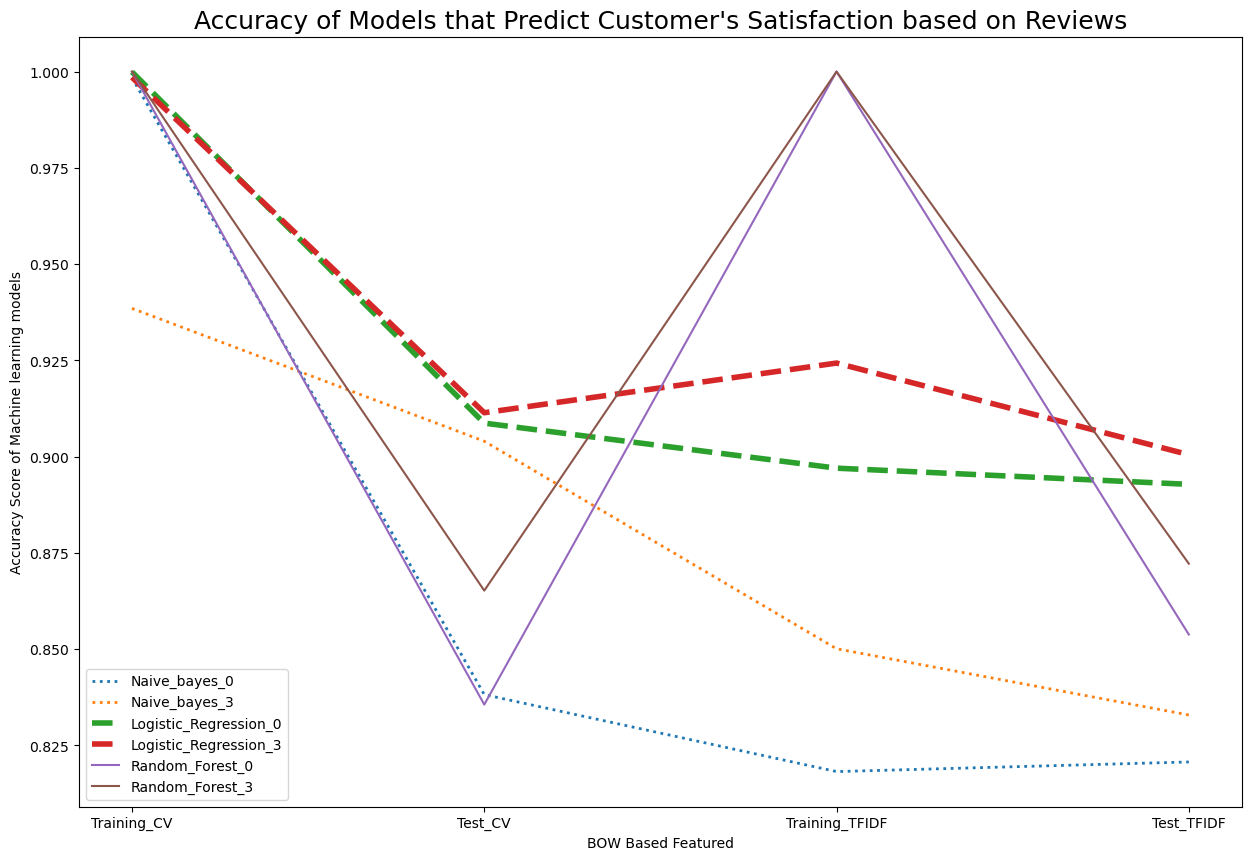

In [43]:
accuracy_df_2 = accuracy_df.iloc[1:]
accuracy_df_2
#creating a line graph to help analyze the best performing model

fig = plt.figure(figsize = (15,10))
ax = plt.axes()

accuracy_df_NB = accuracy_df_2[['Naive_bayes_0','Naive_bayes_3']]
accuracy_df_LR = accuracy_df_2[['Logistic_Regression_0','Logistic_Regression_3']]
accuracy_df_RF = accuracy_df_2[['Random_Forest_0','Random_Forest_3']]


ax.plot(accuracy_df_NB, linestyle='dotted', label=accuracy_df_NB.columns, linewidth = 2)
ax.plot(accuracy_df_LR, linestyle='dashed', label=accuracy_df_LR.columns, linewidth = 4)
ax.plot(accuracy_df_RF,  label=accuracy_df_RF.columns)

plt.legend(loc = 'lower left')
plt.xlabel('BOW Based Featured') 
plt.ylabel('Accuracy Score of Machine learning models') 
plt.title("Accuracy of Models that Predict Customer's Satisfaction based on Reviews",fontsize=18)

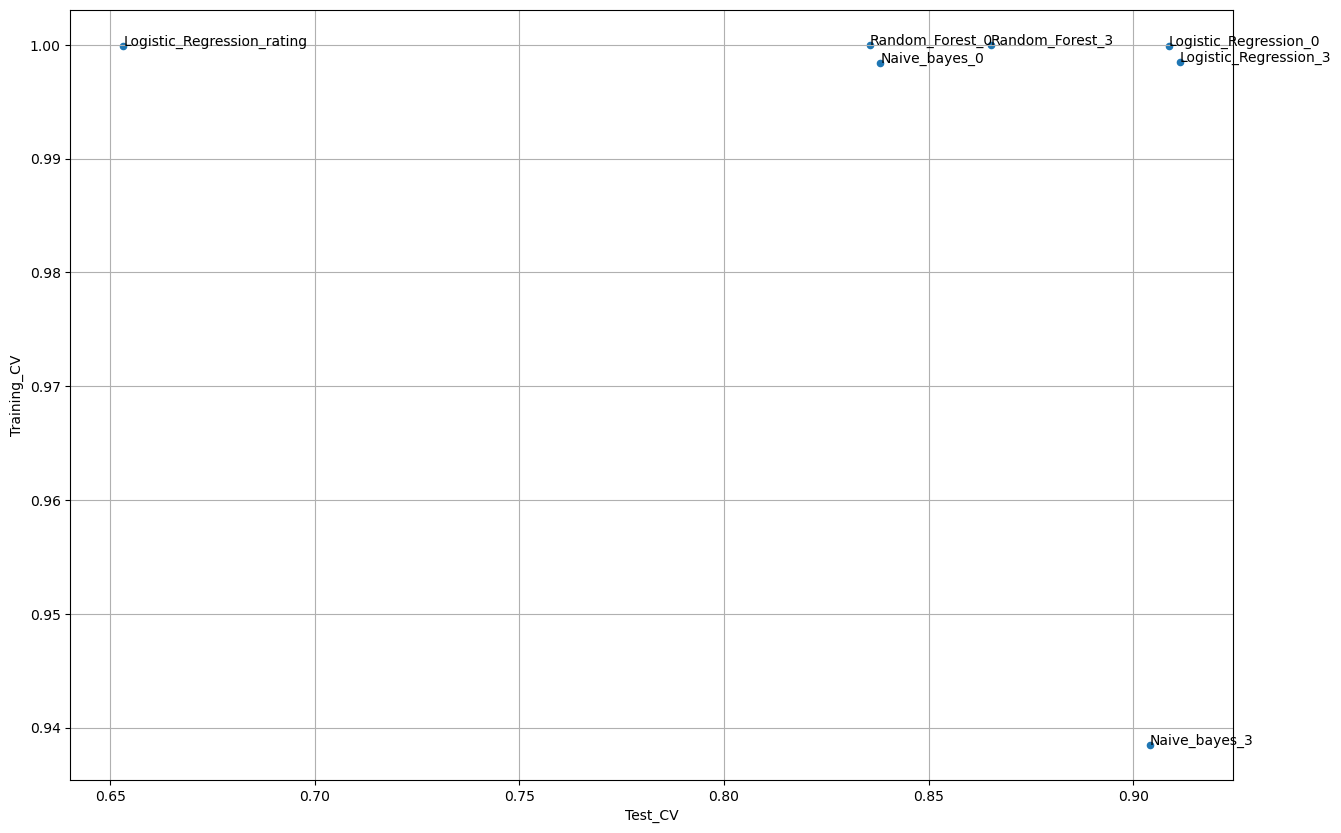

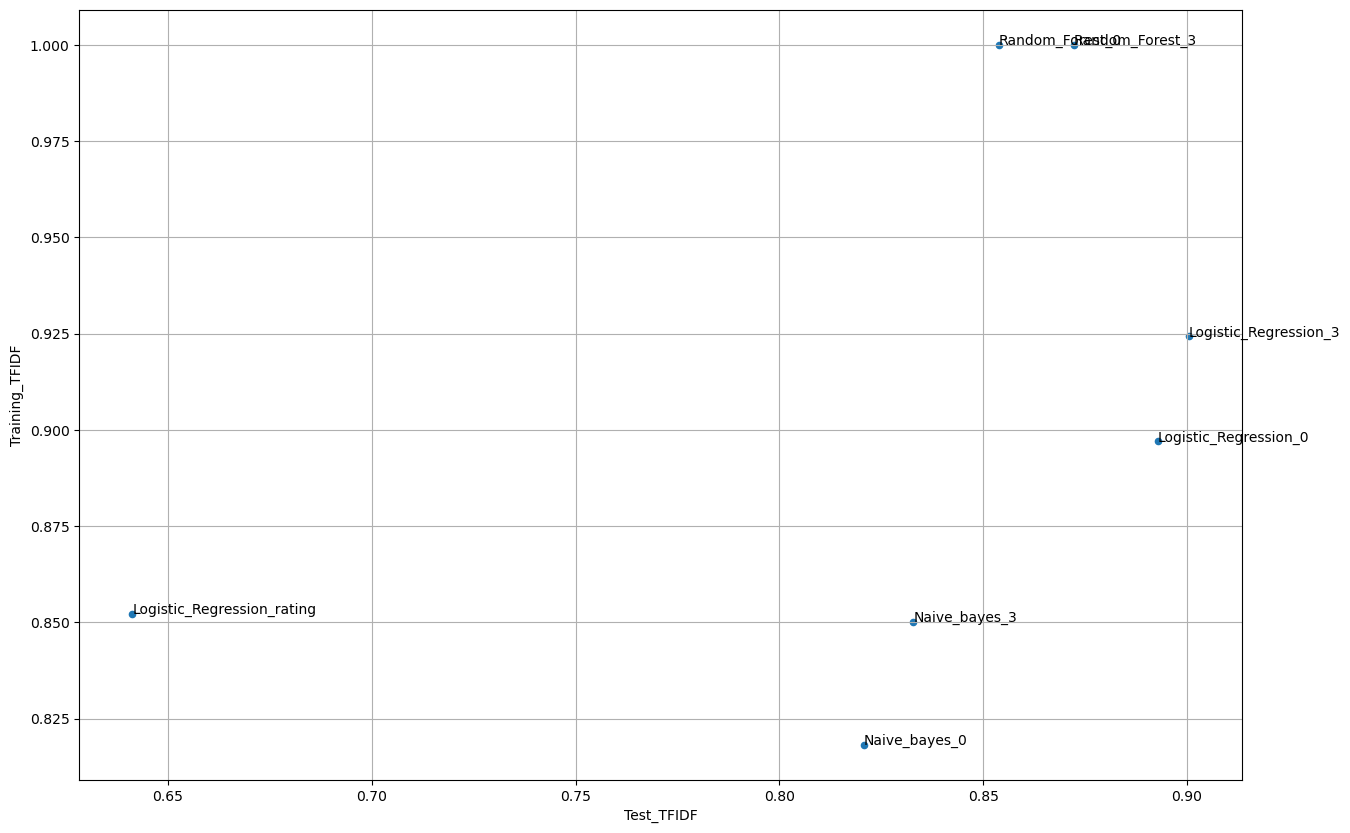

In [44]:
accuracy_df_3 = accuracy_df_2.T
#scatter plot of the training vs test accuracy
accuracy_df_3.plot(kind= 'scatter',y = 'Training_CV', x = 'Test_CV',figsize = (15,10), grid=True)
for idx, row in accuracy_df_3.iterrows(): 
    plt.text(row['Test_CV'], row['Training_CV'], idx)
    
    
accuracy_df_3.plot(kind= 'scatter',y = 'Training_TFIDF', x = 'Test_TFIDF', figsize = (15,10),grid = True)
for idx, row in accuracy_df_3.iterrows(): 
    plt.text(row['Test_TFIDF'], row['Training_TFIDF'], idx)